# MUSHROOMS CLASSIFICATION


## Introduction

The idea of the project is to classify the most common mushroom species in Northen Europe.
This is done using TensorFlow library and Keras, a high level API used to build and train machine learning models, which is capable of running on TensorFlow. 

In [13]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import splitfolders
from tqdm.auto import tqdm
import glob

print(tf.config.list_physical_devices('GPU'))

[]


## Download and prepare the dataset



First of all we divide the all dataset into two folders: training and test with ratio 0.8 and 0.2.

In [5]:
input_folder = './archive/Mushrooms/'
output_folder = './Dataset'

splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.8, 0.2))

Now we divide the training dataset into training and validation images, to perform a better training of the network.

In [9]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

NUM_CLASSES = 4
CLASSES = os.listdir('./Dataset/train/')
print(CLASSES)

from keras.utils import image_dataset_from_directory

(train_data ,validation_data) = image_dataset_from_directory('./Dataset/train/', labels='inferred', 
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=BATCH_SIZE, 
    subset='both', validation_split=0.1, seed=1234)

#test_data = image_dataset_from_directory('./Dataset/test/', labels='inferred', 
#    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=BATCH_SIZE)

['Entoloma', 'Amanita', 'Cortinarius', 'Hygrocybe', 'Lactarius', 'Boletus', 'Russula', 'Suillus', 'Agaricus']
Found 5367 files belonging to 9 classes.
Using 4831 files for training.
Using 536 files for validation.


In the next section we define some functions used to visualize the class distributions.

In [14]:
def get_class_distribution(dataset, to_print=False):
  
  len([name for name in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, name))])

  distribution = []
  total = 0
  classes = []
  for dir in tqdm(os.listdir(dataset)):
    sub_dir = dataset + "/" + dir + "/*"
    number = len(glob.glob(sub_dir)) #len(os.listdir(sub_dir))
    distribution.append(number)
    total += number
    classes.append(dir)
    
  if print:
    for i in range(NUM_CLASSES):
      print(f'Number of {classes[i]}: {distribution[i]}, proportion: {distribution[i]/(total)}')
  
  return distribution, total



def plot_class_distribution(dataset, name):
  distribution, _ = get_class_distribution(dataset, to_print=True)

  plt.figure(figsize=(10, 6), dpi=80)
  plt.bar(CLASSES, height=distribution)
  plt.title(f'Barplot of class distribution of {name} dataset')


100%|██████████| 9/9 [00:00<00:00, 256.56it/s]


Number of Entoloma: 291, proportion: 0.05422023476802683
Number of Amanita: 600, proportion: 0.11179429849077697
Number of Cortinarius: 668, proportion: 0.12446431898639836
Number of Hygrocybe: 252, proportion: 0.046953605366126326


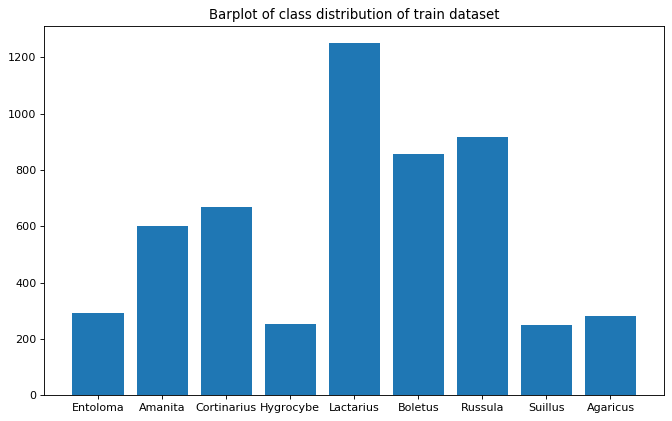

In [15]:
TRAIN_DIR = './Dataset/train/'
plot_class_distribution(TRAIN_DIR, "train")

100%|██████████| 9/9 [00:00<00:00, 617.30it/s]


Number of Entoloma: 73, proportion: 0.054194506310319225
Number of Amanita: 150, proportion: 0.111358574610245
Number of Cortinarius: 168, proportion: 0.12472160356347439
Number of Hygrocybe: 64, proportion: 0.047512991833704527


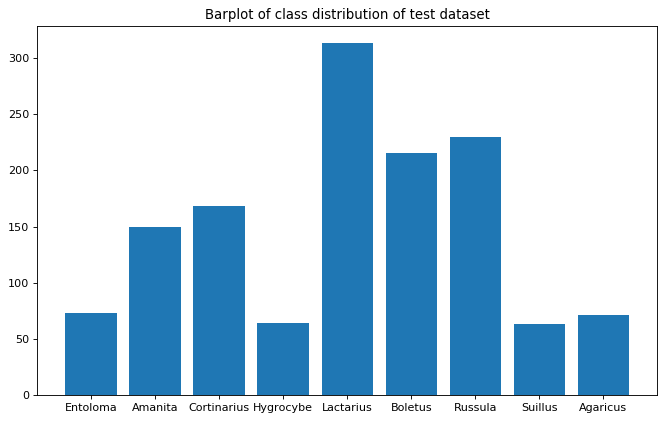

In [16]:
TEST_DIR = './Dataset/test/'
plot_class_distribution(TEST_DIR, "test")

## CNN creation

In [18]:
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn = keras.Model(inputs=inputs, outputs=outputs)

# Check the model
cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

## Training the network

In [21]:
from keras import optimizers

cnn.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



history = cnn.fit(
  train_data,
  epochs=30,
  validation_data=validation_data,
  verbose=1)

Epoch 1/30
126/189 [===================>..........] - ETA: 23s - loss: -719285649408.0000 - accuracy: 0.1173

2023-02-01 12:46:38.393559: E tensorflow/core/lib/jpeg/jpeg_mem.cc:324] Premature end of JPEG data. Stopped at line 494/533


128/189 [===================>..........] - ETA: 22s - loss: -765533356032.0000 - accuracy: 0.1172

InvalidArgumentError: Graph execution error:

jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_3427]

## Plot results data

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()